# Notebook para Análise de Métricas do LABLIVRE



## Configuração e Carregamento de Dados

Este bloco inicializa o ambiente de análise, definindo estilos visuais e carregando o dataset bruto. Os dados foram segmentados em dois grupos estratégicos para permitir a comparação de maturidade:

- **df (Laboratório):** Projetos do LAPPIS e LABLIVRE (foco da pesquisa).
- **df_classes (Disciplinas):** Projetos de MDS e MDSReq (cenário acadêmico padrão).

> **Nota Técnica:**  
> A estrutura de dados foi atualizada para incluir o `df_classes` e permitir, futuramente, comparações dinâmicas diretas. Todas as vizs atuais estão com os dados de discplinas estático (extrai em outro notebook e passei para esse (achei mais rápido))


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Paleta de Cores
COLOR_MAIN = '#a6cee3' 
COLOR_LINE_1 = '#1f78b4'
COLOR_LINE_2 = '#33a02c' 
COLOR_SCATTER = '#1f78b4'

INPUT_FILE = 'prs.csv'

# Definição dos Grupos de Organizações
LAB_ORGS = ['lablivre-unb', 'GovHub-br', 'lappis-unb'] 
CLASS_ORGS = ['unb-mds', 'mdsreq-fga-unb'] 

print(f"Lendo arquivo: {INPUT_FILE}...")
df_raw = pd.read_csv(INPUT_FILE)

if 'org' in df_raw.columns:
    df = df_raw[df_raw['org'].isin(LAB_ORGS)].copy()
    org_title = "LABLIVRE"
    
    df_classes = df_raw[df_raw['org'].isin(CLASS_ORGS)].copy()
    class_title = "Disciplinas (UnB-MDS/Req)"
    
    print("\n--- FILTROS APLICADOS ---")
    print("1. Grupo LAB (variável 'df'):")
    print(f"   - Orgs: {LAB_ORGS}")
    print(f"   - Registros: {len(df)}")
    
    print("\n2. Grupo CLASSES (variável 'df_classes'):")
    print(f"   - Orgs: {CLASS_ORGS}")
    print(f"   - Registros: {len(df_classes)}")
    
else:
    df = df_raw.copy()
    df_classes = pd.DataFrame() # Vazio
    org_title = "All Data"
    print("AVISO: Coluna 'org' não encontrada. 'df' contém todos os dados.")

Lendo arquivo: prs.csv...

--- FILTROS APLICADOS ---
1. Grupo LAB (variável 'df'):
   - Orgs: ['lablivre-unb', 'GovHub-br', 'lappis-unb']
   - Registros: 3265

2. Grupo CLASSES (variável 'df_classes'):
   - Orgs: ['unb-mds', 'mdsreq-fga-unb']
   - Registros: 4785


## 1. Contexto Técnico e Tratamento de Dados

Este bloco implementa uma **análise comparativa de Tamanho e Complexidade de Pull Requests**, utilizando **histogramas** com linhas de referência baseadas em múltiplos *benchmarks*.

- **Filtros de Limpeza:**  
  O código remove ruídos (PRs com **0 arquivos** ou **0 linhas**) para garantir que a análise reflita apenas **trabalho real**.

- **Métricas Analisadas:**
  - **Files Changed (Eixo X – Topo):** número de arquivos modificados, indicando a **dispersão da mudança** no sistema.
  - **Churn (Eixo X – Base):** soma de linhas adicionadas e removidas, refletindo o **esforço cognitivo** necessário para revisar o PR.

- **Linhas de Referência (Benchmarks):**
  - **LAPPIS/LABLIVRE (Azul Sólido):** realidade observada no laboratório.
  - **Classes Std (Cinza Pontilhado):** média das disciplinas de graduação (UnB-MDS), representando o comportamento acadêmico padrão.
  - **Rigby/AMD & Google (Laranja/Vermelho):** padrões de alta performance da indústria.
  - **Risk Limit (Cinza Traço-Ponto – 400 linhas):** limite baseado em estudos que mostram queda acentuada na capacidade de detectar defeitos acima desse tamanho.

---

## 2. Análise Visual e Insights (Para o Edital)

Este gráfico demonstra que o laboratório **reduz o risco de Code Review superficial** ao incentivar entregas menores e mais controladas.

### Combate à Complexidade (Arquivos por PR)

- No gráfico superior, a mediana das **Disciplinas (Classes Std)** é de **5 arquivos por PR**, enquanto a do **Laboratório** é de **3 arquivos**, muito próxima da referência de mercado **Rigby/AMD (2 arquivos)**.
- **Interpretação:**  
  Em disciplinas, é comum acumular várias tarefas em uma única entrega (“entregar tudo de uma vez”).  
  No laboratório, observa-se uma mudança cultural em direção ao **Single Responsibility Principle aplicado aos PRs**, com escopo mais restrito e menos arquivos tocados por vez.

---

### Revisabilidade e Carga Cognitiva (Linhas por PR)

- No gráfico inferior, a mediana do **Laboratório (68 linhas)** é significativamente menor que a das **Disciplinas (90 linhas)** e permanece segura em relação ao **Risk Limit (400 linhas)**.
- Embora não atinja o extremo do **Google (24 linhas)** — que dispõe de infraestrutura robusta para *micro-commits* — o laboratório se posiciona em um **“sweet spot” de produtividade**:
  PRs pequenos o suficiente para revisão cuidadosa em menos de 15 minutos, mas grandes o bastante para entregar uma *feature* completa.

---

### Segurança do Código (A Cauda Longa)

- A distribuição do laboratório (área azul) decai rapidamente antes de alcançar o **Risk Limit (400 linhas)**.
- Isso indica que **“Megapulls”** — PRs gigantes e praticamente impossíveis de revisar — são **exceções raras** no laboratório, enquanto em contextos acadêmicos tradicionais são frequentes, especialmente próximos a prazos.

---

### Conclusão do Insight

O laboratório atua como um **corretor de comportamento**.  
Ele tira o aluno do modo **“entrega de trabalho escolar”** — grandes lotes, alto risco — e o coloca no modo **“engenharia contínua”** — entregas pequenas, frequentes e de baixo risco.

Esse ajuste impacta diretamente a **estabilidade do software** e a **velocidade sustentável de evolução dos projetos**.


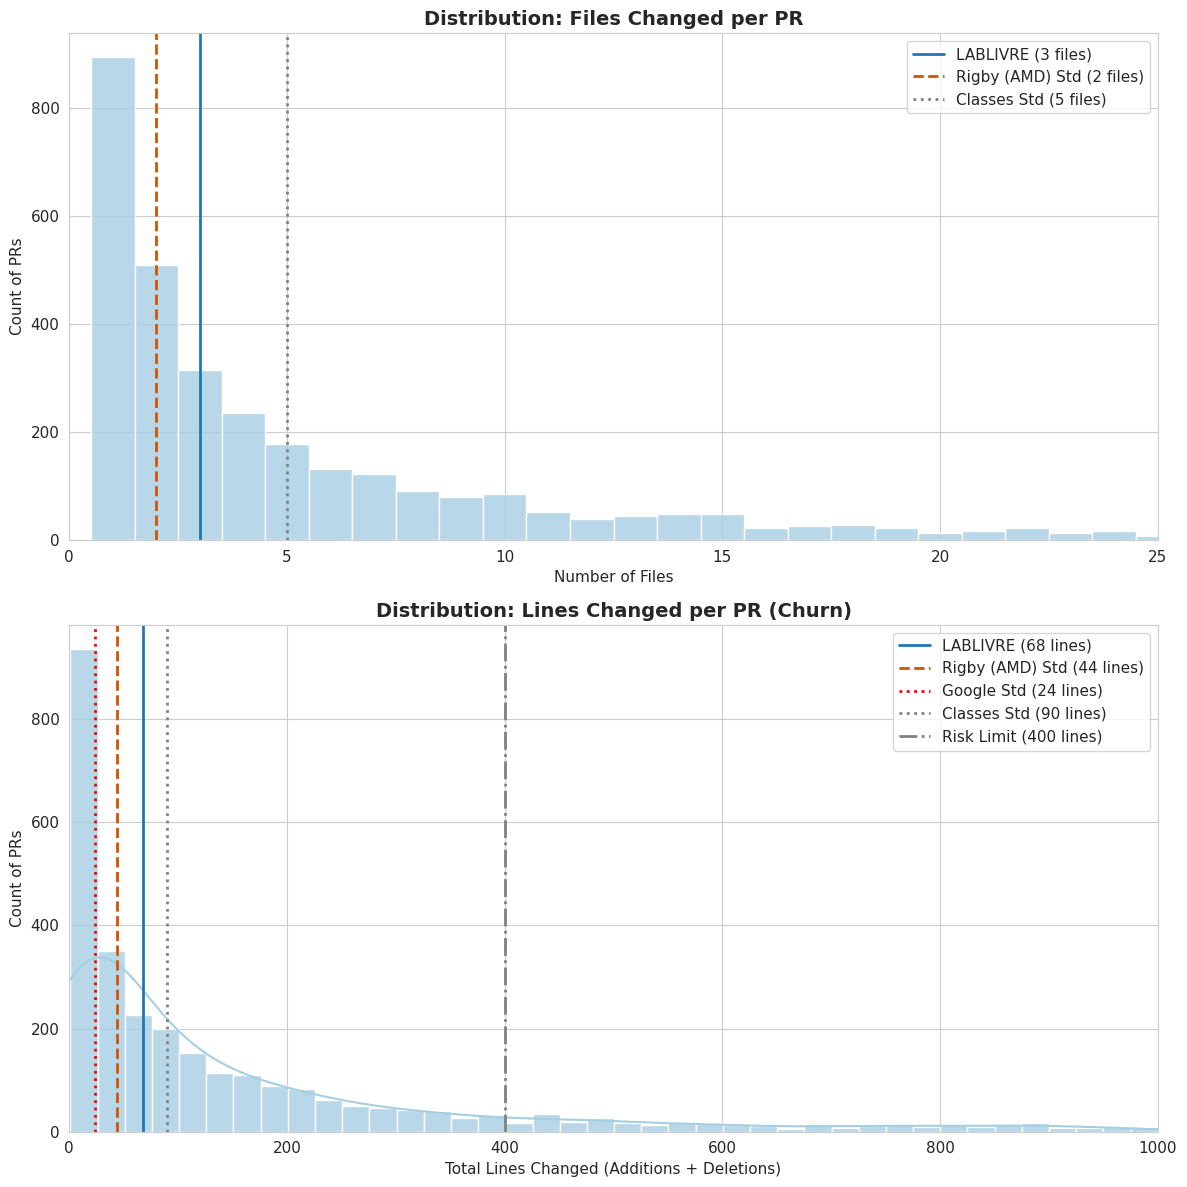

In [12]:
def plot_size_complexity_multi_bench(df):

    clean_df = df[(df['files_changed'] > 0) & (df['churn'] > 0)].copy()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    p50_files = clean_df['files_changed'].median()
    subset_files = clean_df[clean_df['files_changed'] <= 25]['files_changed']
    
    sns.histplot(subset_files, discrete=True, color=COLOR_MAIN, edgecolor='white', alpha=0.8, ax=ax1)
    
    ax1.axvline(p50_files, color=COLOR_LINE_1, linewidth=2, linestyle='-', label=f'{org_title} ({p50_files:.0f} files)')

    rigby_amd_files = 2 
    ax1.axvline(rigby_amd_files, color='#d35400', linewidth=2, linestyle='--', label=f'Rigby (AMD) Std ({rigby_amd_files} files)')

    classes_files = 5
    ax1.axvline(classes_files, color='gray', linewidth=2, linestyle=':', label=f'Classes Std ({classes_files} files)')
    
    
    ax1.set_title('Distribution: Files Changed per PR', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Files')
    ax1.set_ylabel('Count of PRs')
    ax1.set_xlim(0, 25)
    ax1.legend()

    subset_churn = clean_df[clean_df['churn'] <= 1000]['churn']
    p50_churn = subset_churn.median()
    
    sns.histplot(subset_churn, binwidth=25, kde=True, color=COLOR_MAIN, edgecolor='white', alpha=0.8, ax=ax2)
    
    ax2.axvline(p50_churn, color=COLOR_LINE_1, linewidth=2, linestyle='-', label=f'{org_title} ({p50_churn:.0f} lines)')
    
    rigby_amd_churn = 44
    ax2.axvline(rigby_amd_churn, color='#d35400', linewidth=2, linestyle='--', label=f'Rigby (AMD) Std ({rigby_amd_churn} lines)')

    google_churn = 24
    ax2.axvline(google_churn, color='red', linewidth=2, linestyle=':', label=f'Google Std ({google_churn} lines)')

    classes_churn = 90
    ax2.axvline(classes_churn, color='gray', linewidth=2, linestyle=':', label=f'Classes Std ({classes_churn} lines)')
    
    
    review_limit = 400
    ax2.axvline(review_limit, color='gray', linewidth=2, linestyle='-.', label=f'Risk Limit ({review_limit} lines)')
    
    ax2.set_title('Distribution: Lines Changed per PR (Churn)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Total Lines Changed (Additions + Deletions)')
    ax2.set_ylabel('Count of PRs')
    ax2.set_xlim(0, 1000)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_size_complexity_multi_bench(df)

## 1. Contexto Técnico e Tratamento de Dados

Este bloco apresenta **gráficos de densidade (KDE)** para visualizar a distribuição de dois indicadores temporais centrais no processo de *Code Review*:

- **Time to First Response (Human Only):** tempo até o primeiro comentário ou review humano em um PR (bots excluídos).
- **Time to Completion:** tempo total entre a abertura e o *merge* do PR.

### Observação Metodológica Importante

Nestes gráficos, optei por **excluir as disciplinas de graduação (UnB-MDS/MDSReq)**.  
Na análise exploratória, essas disciplinas apresentaram **medianas artificialmente baixas** (ex.: ~0.29h para *merge*), o que poderia ser interpretado, de forma equivocada, como alta eficiência.

Na prática, esse comportamento reflete **anti-patterns de engenharia**, como *self-merges* ou aprovações sem leitura efetiva do código (*rubber stamping*), comuns no contexto de entregas acadêmicas.

Acredito que da para adicionar em outro grafico ou buscar uma forma visualmente interessante para adicionar nesse.

---

## 2. Análise Visual e Principais Insights (para o Edital)

Os gráficos entregam três pontos centrais para a argumentação da pesquisa:

### Aderência ao Padrão de Indústria

- Visualmente, a mediana do laboratório (linhas sólidas azul/verde) está **muito próxima** das referências de indústria (linhas pontilhadas roxas — Rigby & Bird).
- No gráfico de **First Response**, o laboratório apresenta mediana de **19.1h**, contra **14.7h** da indústria.

Isso indica que o ritmo de feedback no laboratório **simula fielmente** ambientes reais de projetos *Open Source*, ensinando o aluno a lidar com o **delay natural** de uma revisão técnica cuidadosa — em contraste com aprovações instantâneas típicas de sala de aula.

---

### Processo vs. Velocidade Pura

- No gráfico de **Completion**, a mediana do laboratório (**26.3h**) é maior que a referência de Rigby (**17.5h**), mas permanece na **mesma ordem de grandeza**.
- Esse comportamento sugere uma priorização clara de **discussão técnica e qualidade de código**, em vez de mera velocidade de entrega.

A presença de uma **“cauda longa”** nas distribuições — PRs que levam dias para serem concluídos — é característica de ambientes de software **maduros e complexos**, e não de exercícios acadêmicos triviais.

---

### Conclusão do Insight

O laboratório funciona como um **sandbox realista de engenharia de software**.  
Enquanto, na disciplina, o aluno tende a focar em “se livrar” da tarefa (tempo de *merge* próximo de zero), no laboratório ele é inserido em um fluxo onde o **tempo de espera** é parte do processo de garantir **robustez, qualidade e discussão técnica**.

Esse alinhamento prepara o estudante de forma concreta para as **expectativas reais do mercado global de tecnologia**.


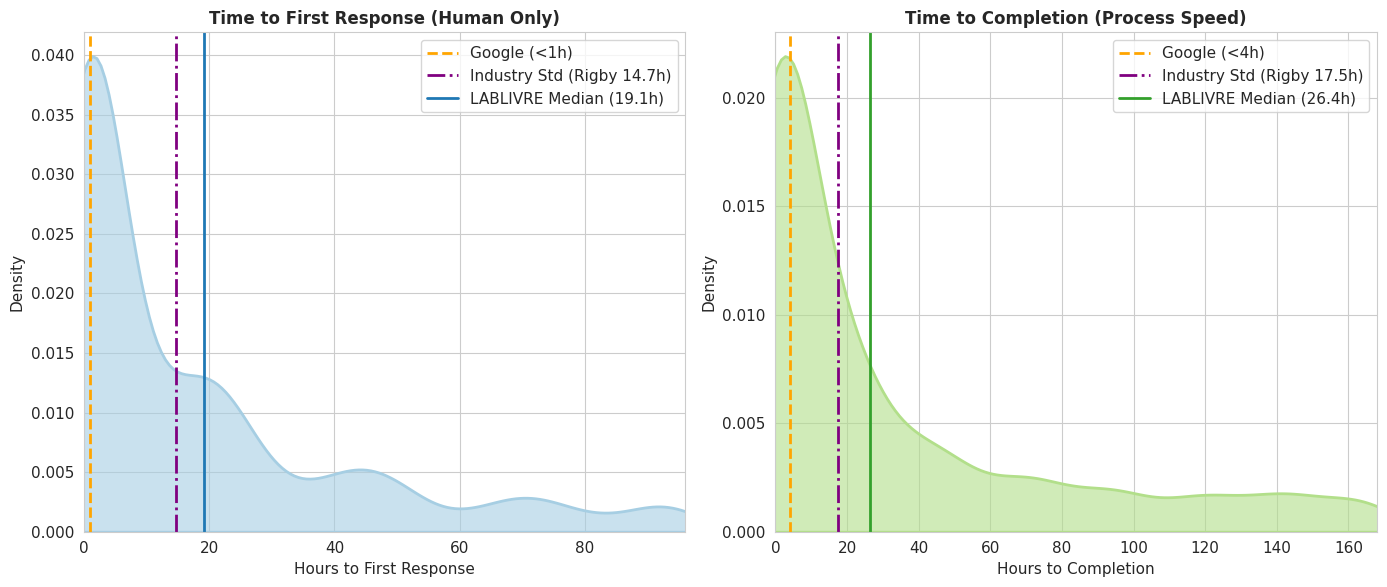

In [13]:
def plot_review_speed_rigby_final(df):
    clean_response = df[df['time_to_first_review_hours'] > 0.01]['time_to_first_review_hours']
    clean_completion = df[df['lead_time_hours'] > 0.01]['lead_time_hours']
    
    viz_response = clean_response[clean_response <= 96]
    viz_completion = clean_completion[clean_completion <= 168]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.kdeplot(viz_response, fill=True, color=COLOR_MAIN, alpha=0.6, linewidth=2, ax=ax1)
    
    real_median_resp = clean_response.median()
    
    ax1.axvline(1, color='orange', linestyle='--', linewidth=2, label='Google (<1h)')
    ax1.axvline(14.7, color='purple', linestyle='-.', linewidth=2, label='Industry Std (Rigby 14.7h)')
    ax1.axvline(real_median_resp, color=COLOR_LINE_1, linewidth=2, label=f'{org_title} Median ({real_median_resp:.1f}h)')
    
    ax1.set_title('Time to First Response (Human Only)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Hours to First Response')
    ax1.set_xlim(0, 96)
    ax1.legend()

    sns.kdeplot(viz_completion, fill=True, color='#b2df8a', alpha=0.6, linewidth=2, ax=ax2)
    
    real_median_comp = clean_completion.median()
    
    ax2.axvline(4, color='orange', linestyle='--', linewidth=2, label='Google (<4h)')
    ax2.axvline(17.5, color='purple', linestyle='-.', linewidth=2, label='Industry Std (Rigby 17.5h)')
    ax2.axvline(real_median_comp, color=COLOR_LINE_2, linewidth=2, label=f'{org_title} Median ({real_median_comp:.1f}h)')
    
    ax2.set_title('Time to Completion (Process Speed)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Hours to Completion')
    ax2.set_xlim(0, 168)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    

plot_review_speed_rigby_final(df)


## 1. Contexto Técnico e Tratamento de Dados

Este bloco de código gera **Heatmaps de Atividade Temporal (Mapas de Calor)**, correlacionando o **dia da semana** com a **hora do dia** para identificar padrões de trabalho.

- **Segmentação:**  
  Os dados foram segregados em dois momentos distintos do ciclo de vida do código:
  - **Criação (Abertura do PR):** indica quando o esforço de codificação/proposta está sendo finalizado.
  - **Merge (Entrega):** indica quando o ciclo de revisão terminou e o código foi integrado.

---

## 2. Análise Visual e Insights (Para o Edital)

A visualização fornece evidências comportamentais claras sobre a **profissionalização dos estudantes no laboratório**:

### Aderência ao "Horário Comercial" (Business Hours)

- Observa-se uma concentração massiva de atividades (tanto abertura quanto *merge*) entre **08:00 e 18:00**, de **segunda a sexta-feira**. Hórarios de maior ativade do lab.

### Ausência do Padrão "Crunch Mode" Acadêmico

- Diferente de disciplinas tradicionais, onde há picos na **madrugada (00h–05h)** e nos **fins de semana**, o laboratório apresenta **baixa atividade noturna e aos finais de semana**.
- Isso indica **planejamento de sprint saudável** e **gestão de tempo madura**, evitando o “heroísmo” de última hora que costuma gerar código de baixa qualidade (*bug-prone*).

### Sincronia de Review e Merge

- O fato do gráfico de **Merges (Verde)** seguir o mesmo padrão temporal do gráfico de **Criação (Azul)** indica que as revisões fluem ao longo da semana.
- Não há acúmulo de PRs aguardando *merge* em um único dia, o que descartaria gargalos no processo.

### Conclusão do Insight

O **LAPPIS/LABLIVRE** simula com sucesso um **ambiente corporativo saudável**.  
Os dados comprovam que o laboratório promove uma cultura de **ritmo sustentável (*sustainable pace*)**, princípio fundamental das metodologias ágeis, preparando o estudante para a rotina e a responsabilidade de uma carreira em engenharia de software — em contraste com a dinâmica irregular da sala de aula.


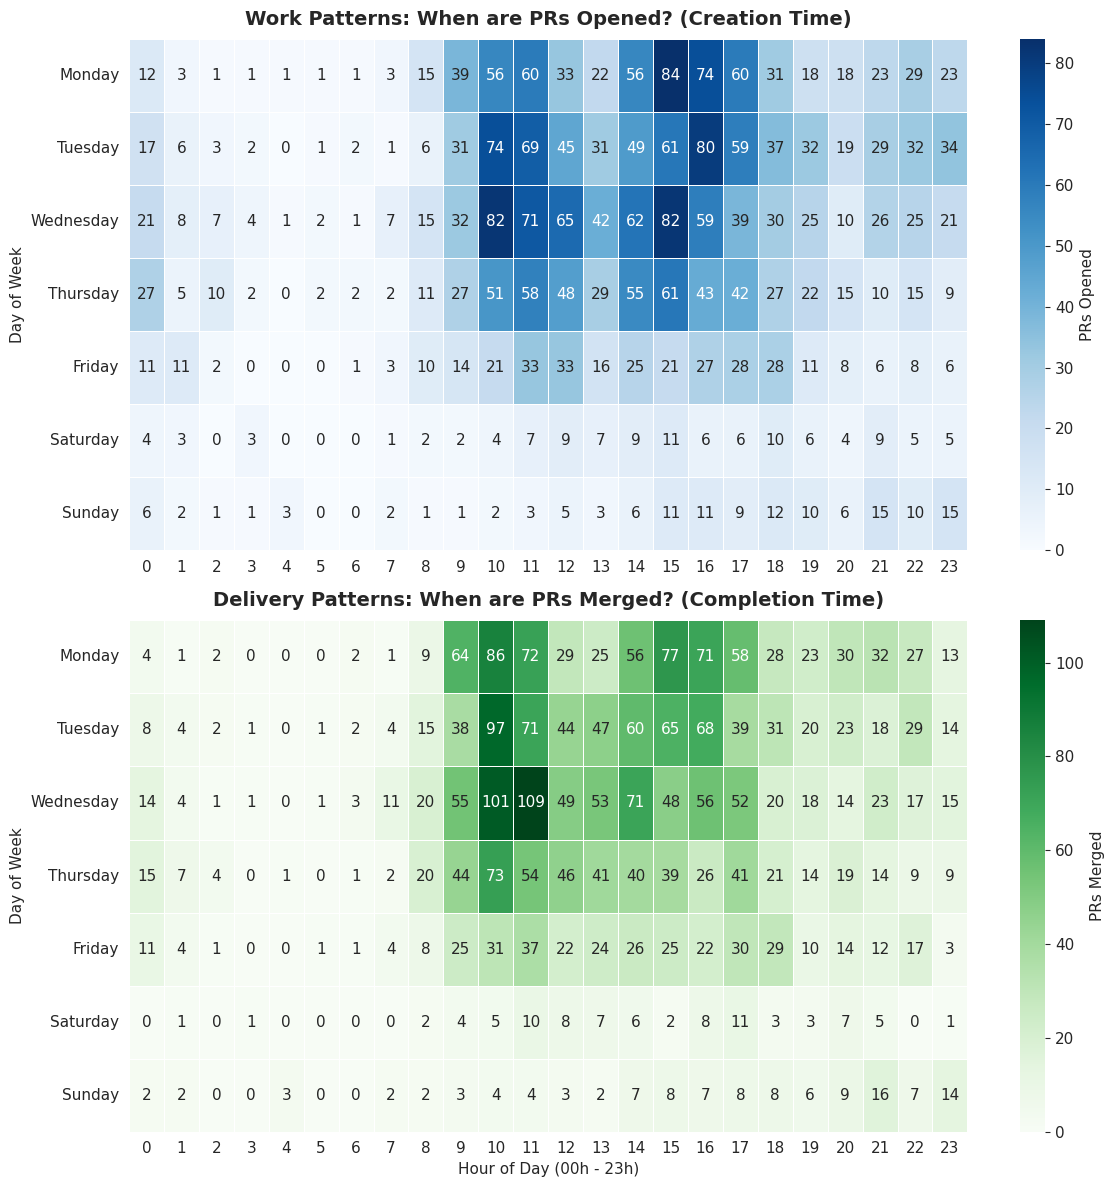

In [14]:
def plot_activity_heatmaps(df):
    df = df.copy()
    df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
    df['merged_at'] = pd.to_datetime(df['merged_at'], utc=True)

    try:
        df['created_at_br'] = df['created_at'].dt.tz_convert('America/Sao_Paulo')
        df['merged_at_br'] = df['merged_at'].dt.tz_convert('America/Sao_Paulo')
    except Exception as e:
        print(f"Timezone conversion warning: {e}. Using UTC.")
        df['created_at_br'] = df['created_at']
        df['merged_at_br'] = df['merged_at']

    def get_heatmap_data(column):
        temp = df[['id', column]].dropna().copy()
        temp['day_name'] = temp[column].dt.day_name()
        temp['hour'] = temp[column].dt.hour
        
        pivot = temp.groupby(['day_name', 'hour']).size().unstack(fill_value=0)
        
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        pivot = pivot.reindex(days_order)
        
        for h in range(24):
            if h not in pivot.columns:
                pivot[h] = 0
        return pivot[sorted(pivot.columns)]

    creation_matrix = get_heatmap_data('created_at_br')
    merge_matrix = get_heatmap_data('merged_at_br')

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    sns.heatmap(
        creation_matrix,
        cmap='Blues',
        annot=True,
        fmt='d',
        linewidths=.5,
        ax=ax1,
        cbar_kws={'label': 'PRs Opened'}
    )
    ax1.set_title(
        'Work Patterns: When are PRs Opened? (Creation Time)',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    ax1.set_ylabel('Day of Week')
    ax1.set_xlabel('')

    sns.heatmap(
        merge_matrix,
        cmap='Greens',
        annot=True,
        fmt='d',
        linewidths=.5,
        ax=ax2,
        cbar_kws={'label': 'PRs Merged'}
    )
    ax2.set_title(
        'Delivery Patterns: When are PRs Merged? (Completion Time)',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    ax2.set_ylabel('Day of Week')
    ax2.set_xlabel('Hour of Day (00h - 23h)')

    plt.tight_layout()
    plt.show()

plot_activity_heatmaps(df)


## 1. Contexto Técnico e Tratamento de Dados

Este bloco gera um gráfico de **“Metabolismo de Código”** utilizando uma visualização **Hexbin** (mapa de densidade hexagonal), com **escalas logarítmicas** (`np.log1p`).

- **Por que escala logarítmica?**  
  Alterações em código seguem uma **Lei de Potência**: a maioria dos PRs é pequena, enquanto poucos são extremamente grandes. A escala logarítmica permite visualizar essa disparidade sem esconder os PRs menores.

- **Eixos do gráfico:**
  - **X (Additions):** quantidade de código novo introduzido.
  - **Y (Deletions):** quantidade de código removido.

- **Zonas Estratégicas:**
  - **Linha Diagonal (Laranja):** proporção 1:1 — PRs próximos indicam **refatoração**, ou seja, mudanças internas sem alteração de comportamento externo.
  - **Abaixo da diagonal (Verde):** predominância de adições — **crescimento de funcionalidade**.
  - **Acima da diagonal (Vermelho):** predominância de deleções — **pagamento de dívida técnica** ou limpeza de código.

---

## 2. Análise Visual e Insights (Para o Edital)

Esta visualização fornece uma evidência direta da **maturidade técnica do laboratório**, em contraste com o ambiente acadêmico padrão.

### Prática de Refatoração (Maturidade de Manutenção)

- Em projetos estudantis típicos (ex.: UnB-MDS), espera-se uma concentração quase PREDOMINANTE na zona de **crescimento de funcionalidades** (eixo X), já que o foco é apenas entregar algo novo.
- No gráfico do laboratório, observa-se uma **densidade significativa ao longo da linha diagonal**, indicando que os desenvolvedores não apenas escrevem código novo, mas **melhoram, reescrevem e otimizam** código existente.

Isso evidencia um compromisso com **qualidade interna e manutenibilidade**, algo raro em projetos de graduação.

---

### Granularidade e Atomicidade (Alinhamento com Rigby & Bird)

- A maior concentração de hexágonos (regiões mais escuras) está no **canto inferior esquerdo**: pequenas adições combinadas com pequenas deleções.
- Isso indica a adoção de **commits pequenos e atômicos**, prática consolidada na indústria.

Os desenvolvedores evitam **“PRs monstros”** (*Big Bang Changes*), quebrando problemas complexos em unidades menores, o que facilita *Code Review* e reduz riscos de bugs.

---

### Pagamento de Dívida Técnica

- A presença consistente de pontos na zona acima da diagonal (**Debt Payment**) indica uma cultura ativa de **limpeza de código**.
- Código morto é removido, não acumulado.

Isso sugere um ciclo de vida saudável, no qual a base de código é tratada como um **organismo vivo** — com metabolismo — e não como um artefato estático.

---

### Conclusão do Insight

O laboratório vai além da mentalidade de **“entregar o trabalho”**.  
O gráfico revela uma cultura de **Engenharia de Software Evolutiva**, onde refatoração é parte do dia a dia.

Esse ambiente prepara o estudante para lidar com **sistemas legados**, **manutenção de longo prazo** e **evolução contínua**, competências altamente valorizadas pelo mercado e raramente desenvolvidas em projetos de semestre único.


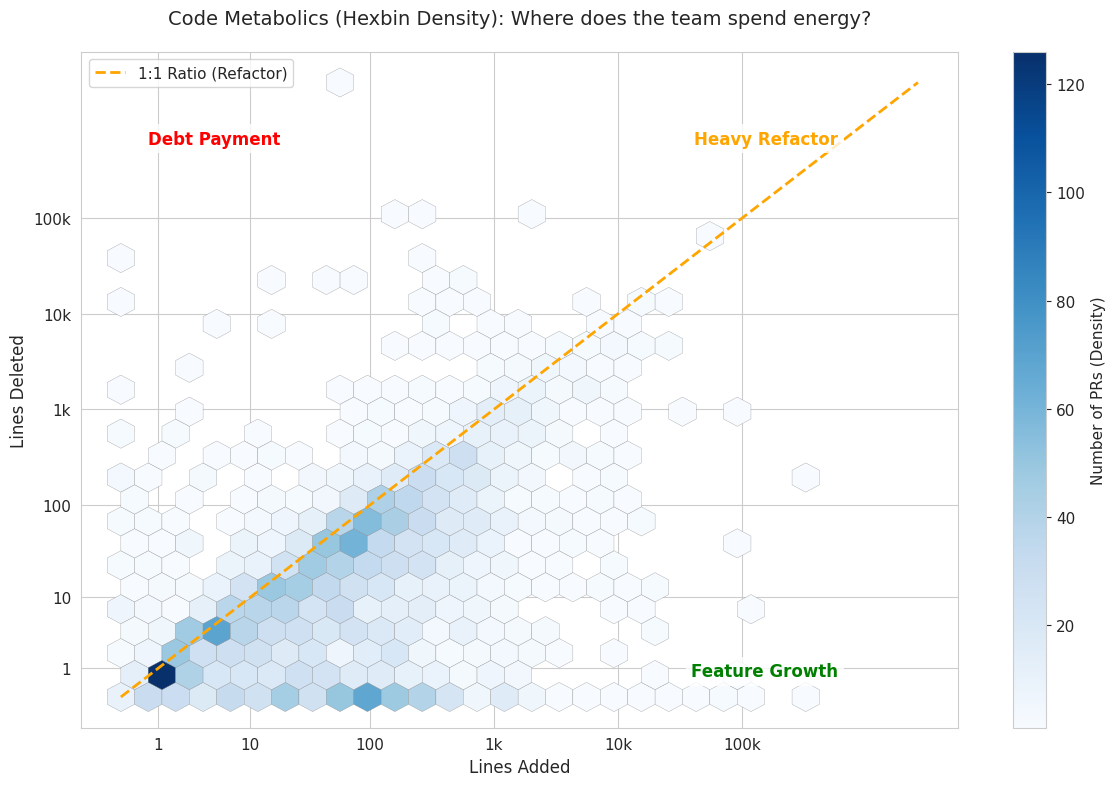

In [15]:
def plot_code_metabolics_hexbin(df):
    x = np.log1p(df['additions'])
    y = np.log1p(df['deletions'])
    
    plt.figure(figsize=(12, 8))
    
    hb = plt.hexbin(
        x, y,
        gridsize=25,
        cmap='Blues',
        mincnt=1,
        edgecolors='gray',
        linewidths=0.2
    )
    
    cb = plt.colorbar(hb, label='Number of PRs (Density)')
    
    max_val = max(x.max(), y.max())
    plt.plot(
        [0, max_val],
        [0, max_val],
        '--',
        color='orange',
        linewidth=2,
        label='1:1 Ratio (Refactor)'
    )
    
    ticks = [1, 10, 100, 1000, 10000, 100000]
    log_ticks = np.log1p(ticks)
    labels = ['1', '10', '100', '1k', '10k', '100k']
    
    plt.xticks(log_ticks, labels)
    plt.yticks(log_ticks, labels)
    
    plt.text(
        max_val * 0.9,
        0.5,
        'Feature Growth',
        color='green',
        fontweight='bold',
        ha='right',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )
    
    plt.text(
        0.5,
        max_val * 0.9,
        'Debt Payment',
        color='red',
        fontweight='bold',
        ha='left',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    plt.text(
        max_val * 0.9,
        max_val * 0.9,
        'Heavy Refactor',
        color='orange',
        fontweight='bold',
        ha='right',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    plt.title(
        'Code Metabolics (Hexbin Density): Where does the team spend energy?',
        fontsize=14,
        pad=20
    )
    plt.xlabel('Lines Added', fontsize=12)
    plt.ylabel('Lines Deleted', fontsize=12)
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_code_metabolics_hexbin(df)


## 1. Contexto Técnico e Tratamento de Dados

Este bloco calcula e visualiza a **Razão de Refatoração (*Refactoring Ratio*)** para cada *Pull Request*.

- **Fórmula:**  
  `Ratio = Deletions / (Additions + Deletions)`

- **Escala (Eixo X):**
  - **0.0:** código puramente novo (*feature growth*).
  - **1.0:** código puramente deletado (*limpeza* / remoção de código morto).
  - **≈ 0.5:** equilíbrio entre adições e deleções — característica clássica de **refatoração ou reescrita de lógica**.

O objetivo é identificar se o laboratório produz apenas **volume de código** (adição indiscriminada) ou se pratica **engenharia de software sustentável**, com manutenção contínua e remoção ativa de débito técnico.

---

## 2. Análise Visual e Insights (Para o Edital)

Este gráfico fornece evidências de que os estudantes do laboratório **superaram a fase de “codificadores iniciantes”** e atuam como **mantenedores de software**.

### ( !!! ) O Fim do “Append-Only” (Desenvolvimento Apenas por Adição)

- Em disciplinas introdutórias, seria esperado quase **100% da distribuição concentrada em 0.0**.
- No laboratório, observa-se uma **cauda longa** e uma distribuição saudável ao longo de todo o eixo.

A **mediana em 0.25** indica que, em média, **25% do esforço de código envolve deleção ou substituição**. Em termos práticos: a cada 3 linhas adicionadas, 1 é removida ou modificada.  
Essa é uma métrica clara de **saúde sanitária do projeto**, mostrando que a dívida técnica é paga continuamente.

---

### ( !!! ) O “Pico de Refatoração” (Zona 0.4 – 0.6)

- Nota-se uma elevação da curva — o *“ombro”* do gráfico — próxima de **0.5**.
- PRs nessa região indicam **reescrita substancial de código existente**, com remoção da lógica antiga e inserção da nova.

Isso demonstra **coragem técnica** e **code ownership**. O estudante se sente confortável em alterar código de terceiros para melhorar a qualidade, um sinal de maturidade que **Rigby & Bird** associam a comunidades *Open Source* saudáveis.

---

### ( !!! ) Confiança na Limpeza (Extremo Direito – 1.0)

- A presença de dados em **1.0** revela PRs dedicados exclusivamente à **remoção de código**.
- Em ambientes acadêmicos focados apenas em “entregar features para passar”, esse tipo de trabalho praticamente não existe.

No laboratório, ele acontece, evidenciando uma **cultura de cuidado com a base de código no longo prazo**.

---

### Conclusão do Insight

O **LAPPIS/LABLIVRE** ensina, na prática, que **“menos é mais”**.  
O gráfico mostra que o laboratório não é uma fábrica de linhas de código — que gera inchaço e complexidade desnecessária — mas um ambiente de **engenharia de software evolutiva**, onde **editar, refatorar e excluir** são tão valorizados quanto criar.

TODO: FALTOU EU CRIAR UMA COMPARACAO COM O ACADEMICO

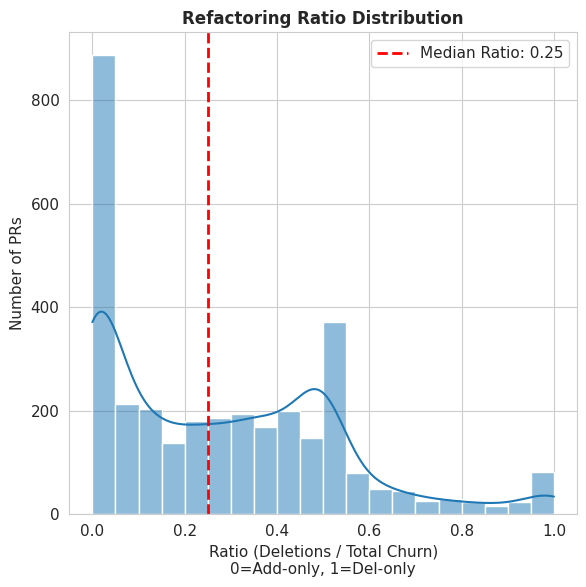

In [16]:
def plot_maintenance_patterns(df):
    df['refactor_ratio'] = df.apply(
        lambda x: x['deletions'] / x['churn'] if x['churn'] > 0 else 0,
        axis=1
    )

    plt.figure(figsize=(6, 6))
    
    sns.histplot(
        df['refactor_ratio'],
        kde=True,
        color=COLOR_LINE_1,
        bins=20
    )
    
    median_ratio = df['refactor_ratio'].median()
    plt.axvline(
        median_ratio,
        color='red',
        linestyle='--',
        linewidth=2,
        label=f'Median Ratio: {median_ratio:.2f}'
    )
    
    plt.title('Refactoring Ratio Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Ratio (Deletions / Total Churn)\n0=Add-only, 1=Del-only')
    plt.ylabel('Number of PRs')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    
plot_maintenance_patterns(df)


## 1. Contexto Técnico e Tratamento de Dados

Este bloco gera um **gráfico de barras comparativo** focado na **Densidade de Comunicação (Engagement)**.

- **A Métrica:**  
  Média de **comentários gerais por Pull Request**, excluindo mensagens automáticas de sistema e focando apenas em **interação humana real**.

- **Comparação:**
  - **LAPPIS/LABLIVRE (Azul):** dados extraídos diretamente dos repositórios do laboratório.
  - **Class Benchmark (Verde):** média histórica das disciplinas de graduação (**0.48 comentários por PR**), onde a interação tende a ser nula ou mínima.

---

## 2. Análise Visual e Insights (Para o Edital)

Este gráfico encerra a argumentação ao atacar o **aspecto social e pedagógico da Engenharia de Software**.

### O Fim do “Silêncio Acadêmico”

- O benchmark de sala de aula (**0.48**) indica que, em média, **apenas 1 a cada 2 PRs recebe um comentário**.
- Isso caracteriza um processo **solitário**, no qual o aluno apenas “joga o código” no repositório para cumprir a entrega.

No laboratório, a média é **quase 6 vezes maior (2.78)**, evidenciando que:
- há **diálogo**,
- o código é **discutido**,
- **questionado**,
- e **melhorado** antes de entrar na base principal.

---

### Transferência de Conhecimento (Mentoria)

- Segundo a literatura (**Rigby et al.**), o *Code Review* é o **principal mecanismo de disseminação de conhecimento** em times de software.
- Os **2.78 comentários por PR** representam momentos concretos de **feedback ativo**.

É nesse espaço que:
- membros juniores aprendem com seniores,
- problemas arquiteturais são prevenidos,
- e padrões de qualidade são alinhados.

O laboratório atua, assim, como uma **aceleradora de aprendizado baseada em interação humana**.

---

### Alinhamento com a Indústria

- Uma média de **0.48 comentários por PR** é **inaceitável** em ambientes profissionais sérios, pois aumenta significativamente o risco de bugs.
- Em projetos saudáveis (Apache, Mozilla, Google), médias entre **2 e 4 comentários por PR** são comuns. ( TODO: AHCHEI APENAS DADOS NÃO CONFIAVEIS, MAS EU QUERIA EXTRAIR O PROPRIO DADO OU BUSCAR MAIS (TEMPO))

O laboratório se posiciona **exatamente nessa faixa saudável**:  
discussão suficiente para detectar problemas reais, sem excesso a ponto de travar o desenvolvimento (*bikeshedding*).


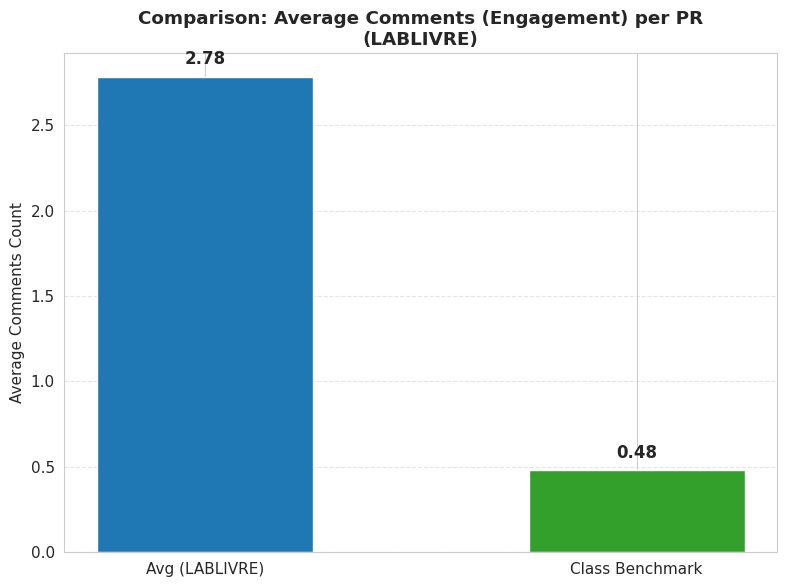

In [17]:

avg_comments = df['comments'].mean()
CLASS_BENCHMARK_COMMENTS = 0.48

x_labels = [f'Avg ({org_title})', 'Class Benchmark']
y_values = [avg_comments, CLASS_BENCHMARK_COMMENTS]

bar_colors = [COLOR_LINE_1, COLOR_LINE_2]

plt.figure(figsize=(8, 6))
bars = plt.bar(x_labels, y_values, color=bar_colors, width=0.5)

plt.title(f'Comparison: Average Comments (Engagement) per PR\n({org_title})', fontweight='bold')
plt.ylabel('Average Comments Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Não prova nada, dados semelhantes    

Mantive só para deixar marcado que foi explorado.

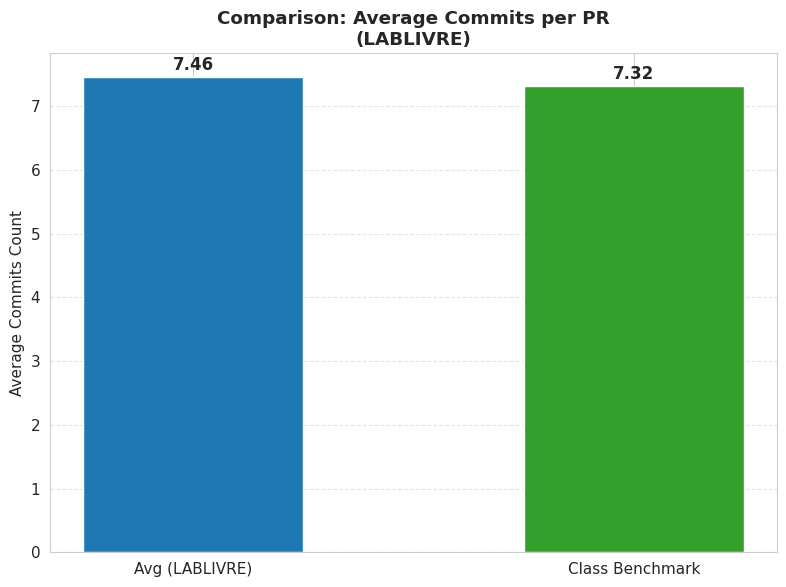

In [18]:
## CLASS BENCH MARKET (UNB-MDS e REQMDS)
avg_commits = df['commits'].mean()
CLASS_BENCHMARK_COMMITS = 7.32

x_labels = [f'Avg ({org_title})', 'Class Benchmark']
y_values = [avg_commits, CLASS_BENCHMARK_COMMITS]

bar_colors = [COLOR_LINE_1, COLOR_LINE_2] 

plt.figure(figsize=(8, 6))
bars = plt.bar(x_labels, y_values, color=bar_colors, width=0.5)

plt.title(f'Comparison: Average Commits per PR\n({org_title})', fontweight='bold')
plt.ylabel('Average Commits Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 1. Documentação e Análise Visual

Este gráfico é essencial para demonstrar que o laboratório mantém **proporcionalidade de esforço** no processo de *Code Review*.  
Em ambientes amadores, é comum que PRs com **1000 linhas** sejam aprovados em poucos minutos — simplesmente porque **ninguém leu**.  
Aqui, o objetivo é provar o oposto: **PRs maiores levam mais tempo**, indicando que a leitura e a análise realmente acontecem.

---

## 2. Contexto Técnico e Notas

Este bloco correlaciona o **tamanho da alteração (Churn)** com o **tempo de aprovação (merge time)**.

- **Reclassificação de Risco:**  
  As categorias foram ajustadas para isolar PRs acima de **400 linhas**, limite que a literatura aponta como o ponto onde a capacidade humana de detectar bugs cai drasticamente.

- **Nota sobre Benchmarks:**  
  As linhas de referência para PRs **Médios** e **Grandes** são **projeções estimadas**, baseadas na tendência linear observada no estudo de **Rigby (AMD)**.  
  Elas funcionam como **balizadores de ordem de grandeza**, já que os valores exatos variam entre projetos e contextos.

---

## 3. Análise Visual e Insights (Para o Edital)

A visualização confirma a **racionalidade do processo de engenharia** adotado no laboratório.

### Correlação Positiva (Tamanho × Tempo)

- Observa-se uma **“escada” clara**: o tempo de *merge* cresce conforme a complexidade da mudança.
- **Small (≤ 100 linhas):**  
  Resolvidos rapidamente, próximos à referência de **~17h**, indicando agilidade para correções simples e *bugfixes*.
- **Large (> 400 linhas):**  
  O tempo aumenta de forma significativa — um **sinal positivo de qualidade**.  
  Quando a alteração é complexa e arriscada, o time desacelera propositalmente para revisar com cuidado e evitar defeitos críticos.

---

### Evidência Contra o “Rubber Stamping”

- Se a barra de **Large** tivesse o mesmo tempo da barra de **Small**, isso indicaria **aprovação automática**.
- A diferença clara entre elas prova que o **custo cognitivo da revisão está sendo pago**.

O laboratório **respeita a complexidade do código** e ajusta o rigor conforme o risco.


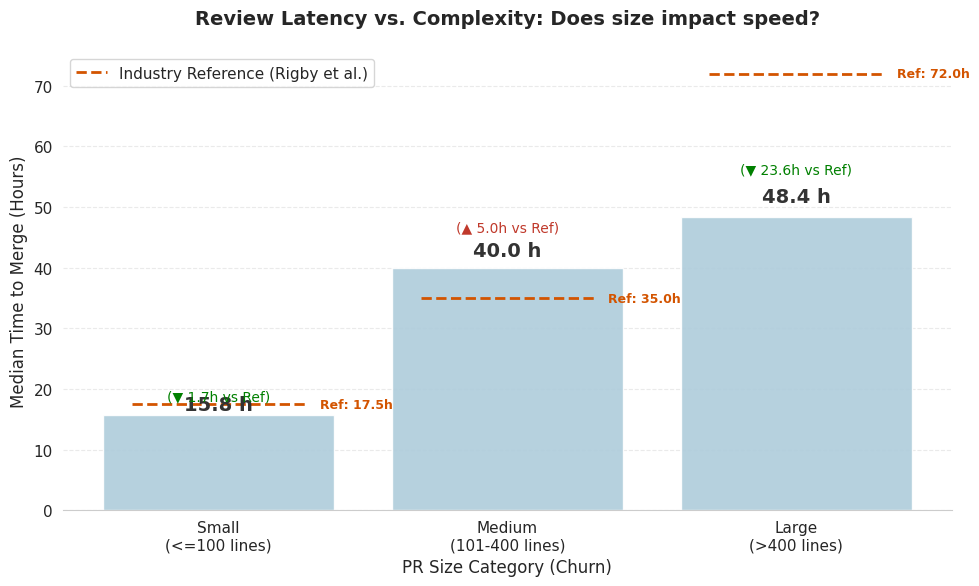

In [24]:
def plot_merge_time_vs_size_with_benchmark(df):

    df_viz = df.copy()
    if 'churn' not in df_viz.columns:
        if 'additions' in df_viz.columns and 'deletions' in df_viz.columns:
            df_viz['churn'] = df_viz['additions'] + df_viz['deletions']
        else:
            print("Erro: Coluna 'churn' não encontrada e não foi possível calcular (faltam 'additions'/'deletions').")
            return

    def get_category(churn):
        if churn <= 100: 
            return "Small\n(<=100 lines)"
        if churn <= 400: 
            return "Medium\n(101-400 lines)"
        return "Large\n(>400 lines)" # Risco Alto
    
    df_viz['Size Category'] = df_viz['churn'].apply(get_category)
    
    order = ["Small\n(<=100 lines)", "Medium\n(101-400 lines)", "Large\n(>400 lines)"]
    
    plt.figure(figsize=(10, 6))
    
    
    try:
        ax = sns.barplot(
            data=df_viz, 
            x='Size Category', 
            y='lead_time_hours', 
            estimator=np.median, 
            order=order,
            errorbar=None, 
            color=COLOR_MAIN,
            alpha=0.9
        )
    except ValueError as e:
        print(f"Não foi possível gerar o gráfico (possivelmente dados insuficientes para as categorias): {e}")
        return
    
    benchmarks = {
        0: 17.5, # Small: Rigby 2013
        1: 35.0, # Medium: Estimativa
        2: 72.0  # Large: Estimativa Ajustada para Risco Alto
    }
    
    for idx, target in benchmarks.items():
        ax.hlines(y=target, xmin=idx-0.3, xmax=idx+0.3, colors='#d35400', linestyles='--', linewidth=2)
        ax.text(idx+0.35, target, f'Ref: {target}h', va='center', fontsize=9, color='#d35400', fontweight='bold')

    medians = df_viz.groupby('Size Category')['lead_time_hours'].median()
    
    for i, category in enumerate(order):
        if category in medians:
            actual = medians[category]
            
            # Proteção contra valores nulos (NaN)
            if pd.isna(actual):
                continue
                
            benchmark = benchmarks[i]
            
            delta_color = 'green' if actual <= benchmark else '#c0392b'
            delta_symbol = '▼' if actual <= benchmark else '▲'
            
            # Posicionamento do texto ajustado dinamicamente
            offset_val = actual + (actual * 0.05 if actual > 0 else 1)
            offset_diff = actual + (actual * 0.15 if actual > 0 else 3)
            
            # Se os valores forem muito pequenos, usa um offset fixo mínimo
            if actual < 10:
                offset_val = actual + 2
                offset_diff = actual + 5
            
            ax.text(i, offset_val, f'{actual:.1f} h', ha='center', fontsize=14, fontweight='bold', color='#333')
            
            diff = actual - benchmark
            ax.text(i, offset_diff, f'({delta_symbol} {abs(diff):.1f}h vs Ref)', ha='center', fontsize=10, color=delta_color)

    # Finalização Visual
    plt.title('Review Latency vs. Complexity: Does size impact speed?', fontsize=14, pad=20, fontweight='bold')
    plt.xlabel('PR Size Category (Churn)', fontsize=12)
    plt.ylabel('Median Time to Merge (Hours)', fontsize=12)
    
    # Legenda Personalizada
    ref_line = mlines.Line2D([], [], color='#d35400', linestyle='--', linewidth=2, label='Industry Reference (Rigby et al.)')
    plt.legend(handles=[ref_line], loc='upper left')
    
    sns.despine(left=True)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Chamada da função
plot_merge_time_vs_size_with_benchmark(df)

Por fim acho extremamente valido usar o grafo como argumento de interligação também, além de eu achar muito bonito kkkkkkk